# DGA Detection
## Building a DGA Classifier
<p id="intro" style="color: green">This is a step-by-step guide on how to detect domains that were generated using "Domain Generation Algorithm" (DGA).<br>
The project is based on Applied Data Science for Security Professionals and <a href="https://github.com/osunjio/applied_data_science_sidi" target="_blank">Sidi Trainings (November 18th, 2020)</a> presented by <a href="https://www.gtkcyber.com/" target="_blank">GTK Cyber</a>.<br><br>
By transforming raw domain strings to Machine Learning features and creating a decision tree classifer we determine whether a given domain is legit or not. Once we have implemented the classifier, the we can evaluate the model. Overview 2 main steps:
<ul style="color: green">
<li>Feature Engineering - from raw domain strings to numeric Machine Learning features using DataFrame manipulations</li>
<li>Machine Learning Classification - predict whether a domain is legit or not using a Decision Tree Classifier</li>
</ul> 
</p>
<a href="#WorkingOn">Go back</a>

In [98]:
# Load libraries 
import pandas as pd
import numpy as np
import regex as re
from collections import Counter
# import pandas_profiling as pp
# from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score  
from sklearn.model_selection import GridSearchCV

from pickle import dump
from pickle import load

<b><h3>Part 1 - Data Preprocessing</h3></b>
<b><p style="color: green">
Note: Here I follow the steps from notebook. The dataset contains 2000 rows vs the full dataset that contains 160003 rows.
</p></b>

In [99]:
df = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1//data/raw/dga_data_small.csv')
df.head()

,isDGA,domain,host,subclass
0,dga,tyopcrkqgxcfm,tyopcrkqgxcfm.co.uk,cryptolocker
1,dga,72j5rn1l9mzleo6203v1ogenfl,72j5rn1l9mzleo6203v1ogenfl.org,gameoverdga
2,dga,thenrest,thenrest.net,nivdort
3,dga,15ihbm71utcnfa8dk1mmgoobl9,15ihbm71utcnfa8dk1mmgoobl9.org,gameoverdga
4,dga,x1d6ou7e7kofk60ayhq74x7e,x1d6ou7e7kofk60ayhq74x7e.net,gameoverdga


In [100]:
# get shape of the data
df.shape

(2000, 4)

In [101]:
# Check for missing values
missing_values = df.isnull().sum()
missing_values

isDGA       0
domain      0
host        0
subclass    0
dtype: int64

In [102]:
# Eliminate duplicates if any and check the shape of the data
df = df.drop_duplicates()
df = df.reset_index(inplace=False, drop=True)
df.shape

(2000, 4)

In [103]:
print(f"DGA: {df['isDGA'].value_counts()['dga']}")
print(f"Legit: {df['isDGA'].value_counts()['legit']}")

DGA: 1000
Legit: 1000


In [104]:
# Count and print 'subclass' column values 
df['subclass'].value_counts()

subclass
alexa           501
legit           499
cryptolocker    462
newgoz          119
necurs          111
nivdort         108
gameoverdga     105
goz              77
bamital          18
Name: count, dtype: int64

<b><h3>Part 2 - Feature Engineering</h3></b>
<b><p style="color: green">
</p></b>

In [105]:
df.drop(['host', 'subclass'], axis=1, inplace=True)
print(df.shape)
df.head()

(2000, 2)


,isDGA,domain
0,dga,tyopcrkqgxcfm
1,dga,72j5rn1l9mzleo6203v1ogenfl
2,dga,thenrest
3,dga,15ihbm71utcnfa8dk1mmgoobl9
4,dga,x1d6ou7e7kofk60ayhq74x7e


In [106]:
# Google's 10000 most common english words [1] will be used to derive a feature called ngram.
# This feature will be used to detect DGA domains
# Load the data
top_english_words = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1//data/raw/google-10000-english.txt', header=None, names=['words'])
top_english_words.head()
d = top_english_words
# Save as pickle file
dump(d, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/raw/top_english_words.pkl', 'wb'))

<p><a href="https://books.google.com/ngrams/info" target="_blank">Google Ngram Viewer</a>: While not specifically a list, Google's Ngram Viewer allows you to search for the frequency of words or phrases in a vast corpus of books over time, which can give you an idea of common words. Please note Google's list of most common English words is not publicly available in real-time.</p>
This <a href="https://github.com/first20hours/google-10000-english">repo</a> contains a list of the 10,000 most common English words in order of frequency, as determined by <a href="https://en.wikipedia.org/wiki/Frequency_analysis">n-gram frequency analysis</a> of the Google's Trillion Word Corpus. 
</br>

#### Feature Engineering
Option 1 to derive Machine Learning features is to manually hand-craft useful contextual information of the domain string. An alternative approach (not covered in this notebook) is "Featureless Deep Learning", where an embedding layer takes care of deriving features - a huge step towards more "AI". Previous academic research has focused on the following features that are based on contextual information:

<b>List of features:</b>
<ol>
<li>Length ["length"]</li>
<li>Number of digits ["digits"]</li>
<li>Entropy ["entropy"] - use H_entropy function provided</li>
<li>Vowel to consonant ratio ["vowel-cons"] - use vowel_consonant_ratio function provided</li>
<li>The index of the first digit - use the firstDigitIndex function provided</li>
<li>N-grams ["n-grams"] - use ngram functions provided</li>
</ol>

In [107]:
def H_entropy (x):
    # Calculate Shannon Entropy
    prob = [ float(x.count(c)) / len(x) for c in dict.fromkeys(list(x)) ] 
    H = - sum([ p * np.log2(p) for p in prob ]) 
    return H

def firstDigitIndex( s ):
    for i, c in enumerate(s):
        if c.isdigit():
            return i + 1
    return 0

# Function to calculate number of digits 
def numDigits(x):
    return sum(c.isdigit() for c in x)

def vowel_consonant_ratio (x):
    # Calculate vowel to consonant ratio
    x = x.lower()
    vowels_pattern = re.compile('([aeiou])')
    consonants_pattern = re.compile('([b-df-hj-np-tv-z])')
    vowels = re.findall(vowels_pattern, x)
    consonants = re.findall(consonants_pattern, x)
    try:
        ratio = len(vowels) / len(consonants)
    except: # catch zero devision exception 
        ratio = 0  
    return ratio

In [108]:
# Transform IsDGA to binary values
df['isDGA'] = df['isDGA'].apply(lambda x: 1 if x == 'dga' else 0)
df.head()

,isDGA,domain
0,1,tyopcrkqgxcfm
1,1,72j5rn1l9mzleo6203v1ogenfl
2,1,thenrest
3,1,15ihbm71utcnfa8dk1mmgoobl9
4,1,x1d6ou7e7kofk60ayhq74x7e


In [109]:
# Extract features from the domain (derive new features)
df['length'] = df['domain'].apply(lambda x: len(x))
df['digits'] = df['domain'].apply(lambda x: numDigits(x))
df['entropy'] = df['domain'].apply(lambda x: H_entropy(x))
df['vowel_cons'] = df['domain'].apply(lambda x: vowel_consonant_ratio(x))
df['firstDigitIndex'] = df['domain'].apply(lambda x: firstDigitIndex(x))
df.head()

,isDGA,domain,length,digits,entropy,vowel_cons,firstDigitIndex
0,1,tyopcrkqgxcfm,13,0,3.546594,0.083333,0
1,1,72j5rn1l9mzleo6203v1ogenfl,26,10,4.132944,0.333333,1
2,1,thenrest,8,0,2.500000,0.333333,0
3,1,15ihbm71utcnfa8dk1mmgoobl9,26,7,4.180833,0.357143,1
4,1,x1d6ou7e7kofk60ayhq74x7e,24,9,3.834963,0.666667,2


In [110]:
# Load pickle file  
with open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/raw/top_english_words.pkl', 'rb') as f:
    d = load(f)

# ngrams: Implementation according to Schiavoni 2014: "Phoenix: DGA-based Botnet Tracking and Intelligence"
def ngrams(word, n):
    # Extract all ngrams and return a regular Python list
    # Input word: can be a simple string or a list of strings
    # Input n: Can be one integer or a list of integers 
    # if you want to extract multipe ngrams and have them all in one list
    
    l_ngrams = []
    if isinstance(word, list):
        for w in word:
            if isinstance(n, list):
                for curr_n in n:
                    ngrams = [w[i:i+curr_n] for i in range(0,len(w)-curr_n+1)]
                    l_ngrams.extend(ngrams)
            else:
                ngrams = [w[i:i+n] for i in range(0,len(w)-n+1)]
                l_ngrams.extend(ngrams)
    else:
        if isinstance(n, list):
            for curr_n in n:
                ngrams = [word[i:i+curr_n] for i in range(0,len(word)-curr_n+1)]
                l_ngrams.extend(ngrams)
        else:
            ngrams = [word[i:i+n] for i in range(0,len(word)-n+1)]
            l_ngrams.extend(ngrams)
#     print(l_ngrams)
    return l_ngrams

def ngram_feature(domain, d, n):
    # Input is domain string or list of domain strings
    # a dictionary object d that contains the count for most common english words
    # finally you n either as int list or simple int defining the ngram length
    
    # Core magic: Looks up domain ngrams in english dictionary ngrams and sums up the 
    # respective english dictionary counts for the respective domain ngram
    # sum is normalized
    
    l_ngrams = ngrams(domain, n)
#     print(l_ngrams)
    count_sum=0
    for ngram in l_ngrams:
        if d[ngram]:
            count_sum+=d[ngram]
    try:
        feature = count_sum/(len(domain)-n+1)
    except:
        feature = 0
    return feature
    
def average_ngram_feature(l_ngram_feature):
    # input is a list of calls to ngram_feature(domain, d, n)
    # usually you would use various n values, like 1,2,3...
    return sum(l_ngram_feature)/len(l_ngram_feature)

<div class="alert alert-block alert-info">
<b>N-grams functions:</b> Steps involved in the code above:
<ol>
    <li>We have the 10000 most common english words (I create the DataFrame as "d = top_english_words" that I save as pickle file in this notebook, then the file is loaded). Now we run the ngrams functions on a list of all these words. The output here is a list that contains ALL 1-grams, bi-grams and tri-grams of these 10000 most common english words.</li>
    <li>We use the Counter function from collections to derive a dictionary d that contains the counts of all unique 1-grams, bi-grams and tri-grams.</li>
    <li>Our ngram_feature function will do the core magic. It takes your domain as input, splits it into ngrams (n is a function parameter) and then looks up these ngrams in the english dictionary d we derived in step 2. Function returns the normalized sum of all ngrams that were contained in the english dictionary. For example, running ngram_feature('facebook', d, 2) will return 171.28 (this value is just like the one published in the Schiavoni paper).</li>
    <li>Finally average_ngram_feature wraps around ngram_feature. You will use this function as your task is to derive a feature that gives the average of the ngram_feature for n=1,2 and 3. Input to this function should be a simple list with entries calling ngram_feature with n=1,2 and 3, hence a list of 3 ngram_feature results.</li>
    <li>Then we should apply average_ngram_feature to domain column and aad ngram to the df</li>
    <li>Finally drop the domain column from the DataFrame</li>
<ol>
</div>
<b><span style="color: red">Check the original Github repository <a href="https://github.com/osunjio/applied_data_science_sidi/blob/78e6da047845d071667bb887e28a5c120c8e6a12/notebooks/Worksheet%204%20-%20Feature%20Engineering.ipynb" target="_blank">here</a></span></b>

<div class="alert alert-block alert-danger">
<b>Important:</b> Below we should see the result of running the code above and after having applied the ngrams functions,added ngrams as a new feature in the dataset original dataset "df" and having dropped the 'domain' column. Because I couldn't run the function and fix the errors, I had to use the processed dataset "dga_features_final_df.csv".
</div>

In [111]:
# Here we use the dga_features_final_df.csv file which already dropped the 'domain' column
df_final = pd.read_csv('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/data/processed/dga_features_final_df.csv')
print(df_final.shape)
print(df_final['isDGA'].value_counts())

(2000, 7)
isDGA
1    1000
0    1000
Name: count, dtype: int64


In [112]:
df_final.head()

,isDGA,length,digits,entropy,vowel-cons,firstDigitIndex,ngrams
0,1,13,0,3.546594,0.083333,0,744.670940
1,1,26,10,4.132944,0.333333,1,715.217265
2,1,8,0,2.500000,0.333333,0,1918.797619
3,1,26,7,4.180833,0.357143,1,682.269402
4,1,24,9,3.834963,0.666667,2,544.178140


In [113]:
# feature_names = ['length', 'digits', 'entropy', 'vowel-cons', 'firstDigitIndex', 'ngrams']
# features = df_final[feature_names]
# target = df_final['isDGA']

In [ ]:
# Now we want to visualize the features to see which will be of value and which will not be of value 
# Plot the distribution of the features
fig, axes = plt.subplots(3, 2, figsize=(15, 15))
fig.suptitle('Feature Distribution')

sns.histplot(data=df_final, x='length', hue='isDGA', ax=axes[0, 0])
sns.histplot(data=df_final, x='digits', hue='isDGA', ax=axes[0, 1])
sns.histplot(data=df_final, x='entropy', hue='isDGA', ax=axes[1, 0])
sns.histplot(data=df_final, x='vowel-cons', hue='isDGA', ax=axes[1, 1])
sns.histplot(data=df_final, x='firstDigitIndex', hue='isDGA', ax=axes[2, 0])
sns.histplot(data=df_final, x='ngrams', hue='isDGA', ax=axes[2, 1])

plt.show()

In [115]:
# From the above plots, we can see that the features 'length', 'digits', 'entropy', 'vowel-cons', 'firstDigitIndex' 
# are not very useful in distinguishing between DGA and Legit domains.
# The feature 'ngrams' seems to be the most useful feature in distinguishing between DGA and Legit domains.

In [116]:
# using seaborn pairplot to visualize the correlation between features
# sns.pairplot(df_final, hue='isDGA')
# plt.show()

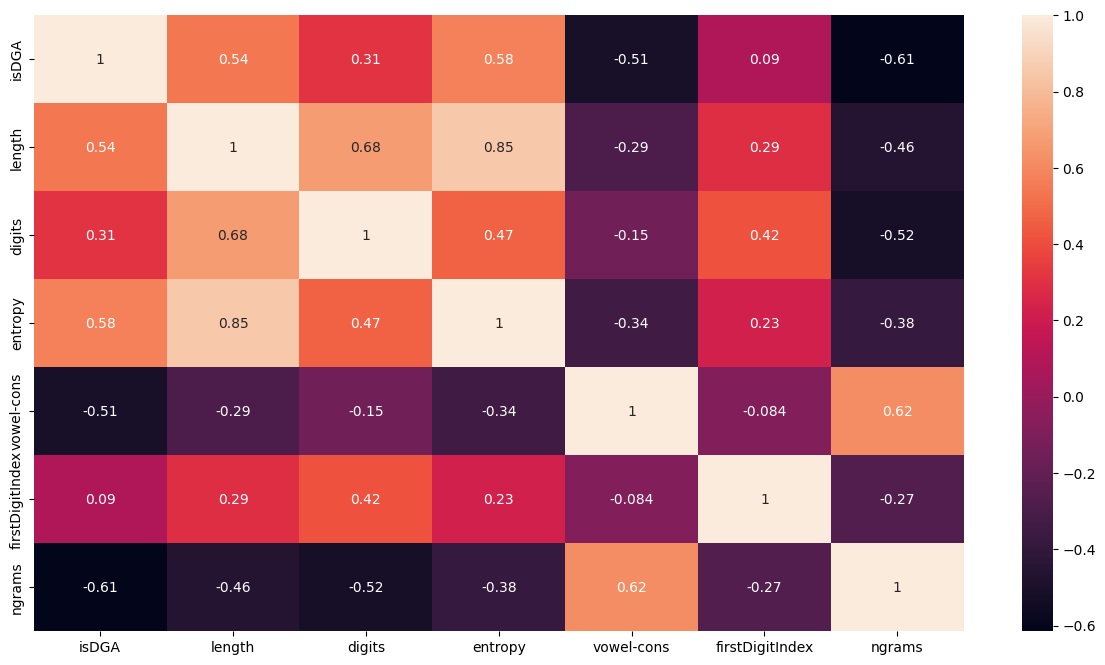

In [117]:
# Correalation matrix
corr = df_final.corr()
plt.figure(figsize=(15, 8))
sns.heatmap(corr, annot=True)   
plt.show()

In [118]:
# from the correlation matrix we can see that the ngrams feature has a high correlation with the target variable along with the entropy feature and the length feature
# we can see that the ngrams feature has a high correlation with the target variable along with the entropy feature and the length feature
# Now we are going to use the ngrams feature to build a model to predict DGA domains
df_final.head()

,isDGA,length,digits,entropy,vowel-cons,firstDigitIndex,ngrams
0,1,13,0,3.546594,0.083333,0,744.670940
1,1,26,10,4.132944,0.333333,1,715.217265
2,1,8,0,2.500000,0.333333,0,1918.797619
3,1,26,7,4.180833,0.357143,1,682.269402
4,1,24,9,3.834963,0.666667,2,544.178140


<b><h3>Part 3 - Training the model</h3></b>

In [119]:
# Split the data into features and target
# We are going to use the features 'ngrams', 'entropy' and 'length' to build a decision tree classifier
X = df_final[['ngrams', 'entropy', 'length']]
y = df_final['isDGA']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Build a decision tree classifier
clf = DecisionTreeClassifier(random_state=42)
clf.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [120]:
# Predict the target variable
y_pred = clf.predict(X_test)

In [121]:
# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 87.50%


In [122]:
# Save the model
dump(clf, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_clf_42.pkl', 'wb'))

In [123]:
# optimize the model using GridSearchCV
hyperparameters = {'criterion': ['gini', 'entropy', 'log_loss'], # The criterion to be used to split the data (gini or entropy)
                     'max_depth': [None, 5, 15, 20, 25], # The maximum depth of the tree 
                     'min_samples_split': [2, 5, 10, 20], # The minimum number of samples required to split an internal node
                     'min_samples_leaf': [1, 2, 4, 5]} # The minimum number of samples required to be at a leaf node

grid = GridSearchCV(clf, hyperparameters, scoring='accuracy', cv=10) # Create the grid search model with the model, hyperparameters, scoring method and cross-validation
grid

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_depth': [None, 5, 15, 20, 25],
                         'min_samples_leaf': [1, 2, 4, 5],
                         'min_samples_split': [2, 5, 10, 20]},
             scoring='accuracy')

In [124]:
grid.fit(X_train, y_train) # Fit the grid search model to the training data
print(f"Best hyperparameters: {grid.best_params_}") # Print the best parameters

Best hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 20}


In [125]:
clf_optimized = DecisionTreeClassifier(criterion='gini', max_depth=5, min_samples_leaf=4, min_samples_split=20, random_state=42)
clf_optimized.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=4, min_samples_split=20,
                       random_state=42)

In [126]:
y_pred_optimized = clf_optimized.predict(X_test)
accuracy_optimized = accuracy_score(y_test, y_pred_optimized)
print(f"Accuracy: %.2f%%" % (accuracy_optimized * 100.0))

Accuracy: 91.50%


In [127]:
# Save the model
dump(clf_optimized, open('C:/Users/Jorge Payà/Desktop/4Geeks/Final Project/Code/DGA-detection-project1/models/dga_clf_42_gini_maxdp-5_minsmpl-4_minsmpp-20.pkl', 'wb'))

In [128]:
# Let's check model performance on a single domain name

<a id="WorkingOn" href="#intro">Go up</a>

### References
<ul>
    <li>Google Ngram Viewer, <a href="https://books.google.com/ngrams/info" target="_blank">link</a></li>
    <li>n-gram frequency analysis, <a href="https://en.wikipedia.org/wiki/Frequency_analysis">link</a></li>
    <li>Github repository of list of the 10,000 most common English words in order of frequency, <a href="https://github.com/first20hours/google-10000-english">link</a></li>
    <li></li>
    <li></li>
    <li></li>
</ul>